In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Large-scale power loss in ground-based CMB mapmaking
Naess, Sigurd ; Louis, Thibaut



In [2]:
npix = 10
nsamp = 100
pix = np.arange(nsamp).astype(float)*npix/nsamp
#A standard nearest-neighbor pointing matrix for this looks like:

P = np.zeros((nsamp,npix))
for i, p in enumerate(pix):
    P[i,int(np.round(pix[i]))%npix] = 1


freq = np.fft.rfftfreq(nsamp)
print(freq)
inv_ps = 1/(1+(np.maximum(freq,freq[1]/2)/0.03)**-3.5)
F = np.zeros((nsamp,nsamp))
I = np.eye(nsamp)
for i in range(nsamp):
    F[:,i] = np.fft.irfft(inv_ps*np.fft.rfft(I[i]), n=nsamp)
#The signal itself consists of just a long-wavelength sine wave:5
print(F[0,0],F[99,99])
signal = np.sin(2*np.pi*pix/npix)


[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5 ]
0.931157641667902 0.931157641667902


Text(0, 0.5, '$t_2$')

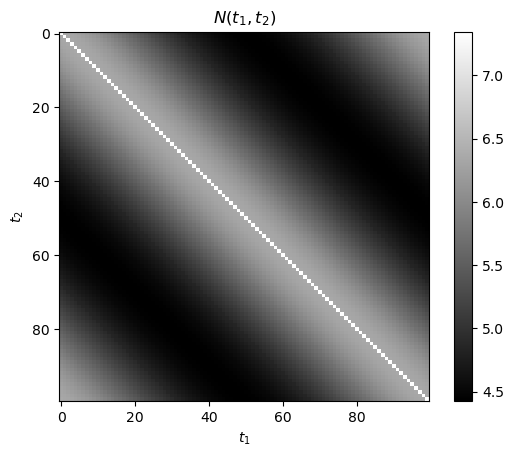

In [3]:
plt.imshow(np.linalg.inv(F), cmap='gray')  # Use 'gray' for grayscale images, or other colormaps
plt.colorbar()  # Add a colorbar to show the value mapping
plt.title('$N(t_1,t_2)$')
plt.xlabel('$t_1$')
plt.ylabel('$t_2$')


Text(0, 0.5, 'Signal')

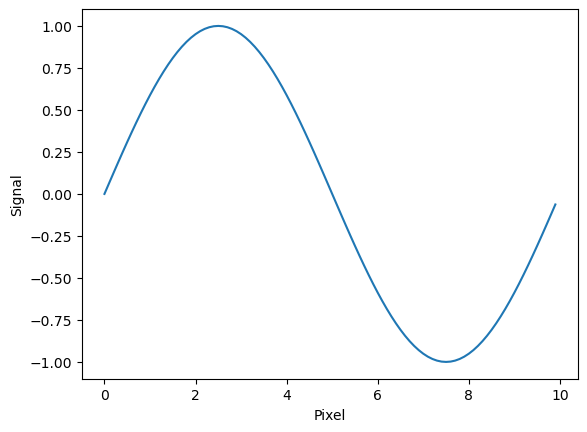

In [4]:
plt.plot(pix,signal)
plt.xlabel('Pixel')
plt.ylabel('Signal')
#plt.plot(range(nsamp),pix)

Text(0.5, 0, 'Time')

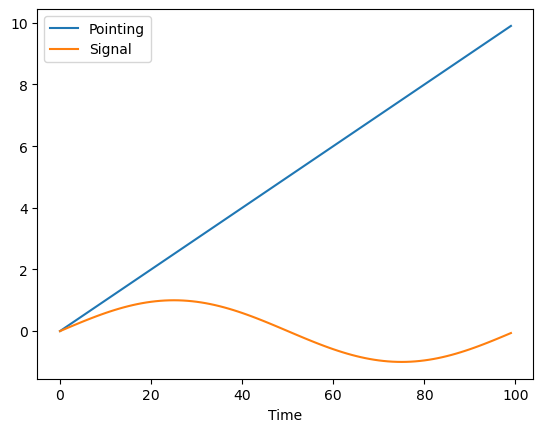

In [5]:
plt.plot(range(nsamp),pix,label='Pointing')
plt.plot(range(nsamp),signal,label='Signal')
plt.legend()
plt.xlabel('Time')

In [6]:
map_binned = np.linalg.solve((P.T.dot(P)), P.T.dot(signal)) ## Solves P^TP (map) = P^T data
map_ml = np.linalg.solve((P.T.dot(F).dot(P)),P.T.dot(F.dot(signal)))
map_fb = np.linalg.solve(P.T.dot(P), P.T.dot(F).dot(signal))
obsmat = np.linalg.inv(P.T.dot(P)).dot(P.T.dot(F).dot(P))
#and using it, we can define a debiased filter+bin map

map_fb_deobs = np.linalg.solve(obsmat, map_fb)

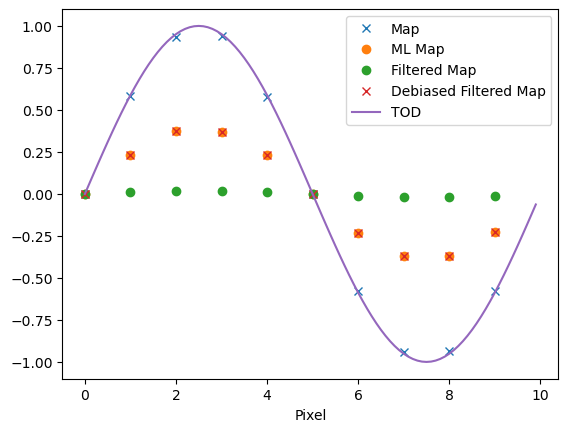

In [7]:
plt.plot(range(npix),map_binned,'x',label='Map')
plt.plot(range(npix),map_ml,'o',label='ML Map')
plt.plot(range(npix),map_fb,'o',label='Filtered Map')
plt.plot(range(npix),map_fb_deobs,'x',label='Debiased Filtered Map')
plt.plot(pix,signal,label='TOD')
plt.xlabel('Pixel')
plt.legend()

## Signal To Noise

In [8]:
# First look at the signal to noise from the above example. Take the signal in each pixel to be the mean of all samples in that pixel.
# What is called signal there is really the data. So add noise to the signal


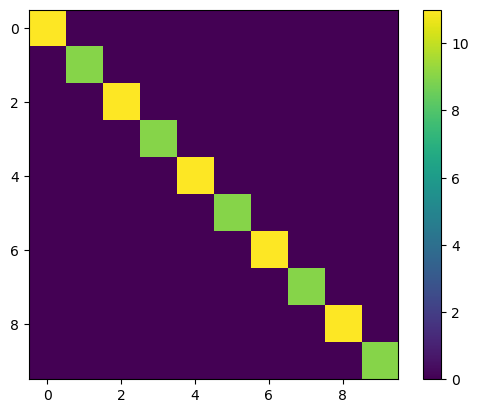

In [9]:
plt.imshow(P.T.dot(P))
plt.colorbar()

In [10]:
for i in range(npix):
    print(P.T.dot(P)[i,i])

11.0
9.0
11.0
9.0
11.0
9.0
11.0
9.0
11.0
9.0


In [11]:

# Define the mean (zero vector)
mean = np.zeros(nsamp)

# Define a random covariance matrix N (must be positive semi-definite)
# Example: Generating a symmetric positive-definite matrix
A = np.random.randn(nsamp, nsamp)
N = np.linalg.inv(F)

# Draw 100 samples from the multivariate normal distribution
noise = np.random.multivariate_normal(mean, N, size=1).flatten()  # Shape: (100,)




In [12]:
data=signal+noise
data_map_binned = np.linalg.solve((P.T.dot(P)), P.T.dot(data)) ## Solves P^TP (map) = P^T data
data_map_ml = np.linalg.solve((P.T.dot(F).dot(P)),P.T.dot(F.dot(data)))

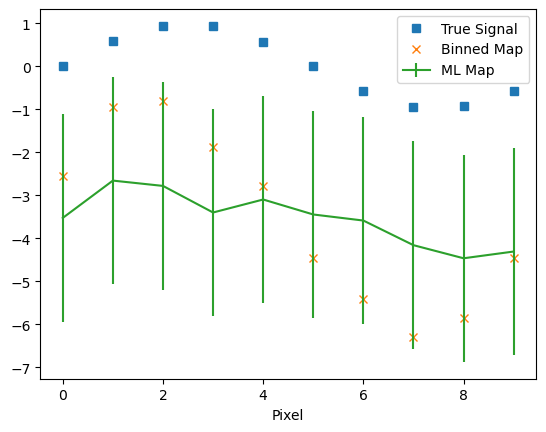

In [13]:
plt.plot(range(npix),map_binned,'s',label='True Signal')
plt.plot(range(npix),data_map_binned,'x',label='Binned Map')
error=np.sqrt(np.diag(np.linalg.inv(P.T.dot(F).dot(P))))
plt.errorbar(range(npix),data_map_ml,yerr=error,label='ML Map')
plt.xlabel('Pixel')
plt.legend()

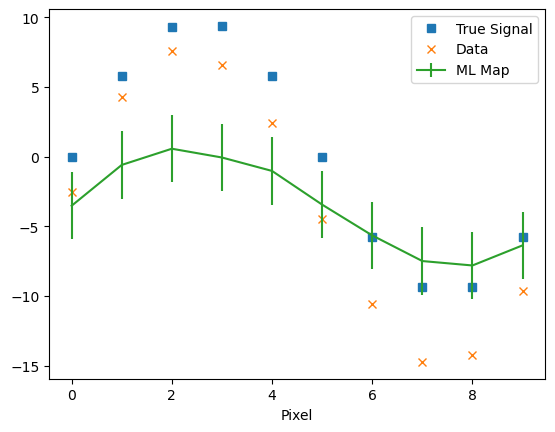

In [14]:
## Suppose the signal to noise is much larger: 
sn=10
signal = sn*np.sin(2*np.pi*pix/npix)
data=signal+noise
data_map_binned = np.linalg.solve((P.T.dot(P)), P.T.dot(data)) ## Solves P^TP (map) = P^T data
data_map_ml = np.linalg.solve((P.T.dot(F).dot(P)),P.T.dot(F.dot(data)))
plt.plot(range(npix),sn*map_binned,'s',label='True Signal')
plt.plot(range(npix),data_map_binned,'x',label='Data')
error=np.sqrt(np.diag(np.linalg.inv(P.T.dot(F).dot(P))))
plt.errorbar(range(npix),data_map_ml,yerr=error,label='ML Map')
plt.xlabel('Pixel')
plt.legend()

In [15]:
sigma = 0.5  # Beam width in pixel units
Pw = np.zeros((nsamp, npix))

for i, p in enumerate(pix):
    for j in range(npix):
        Pw[i, j] = np.exp(-0.5 * ((p - j) / sigma) ** 2)  # Gaussian weight

    Pw[i, :] /= np.sum(Pw[i, :])  # Normalize row to sum to 1

print(Pw[:5])


[[8.80536890e-01 1.19167709e-01 2.95387219e-04 1.34105590e-08
  1.11512649e-14 1.69833539e-22 4.73745239e-32 2.42040660e-43
  2.26492524e-56 3.88187447e-71]
 [8.31501844e-01 1.67877327e-01 6.20787476e-04 4.20451514e-08
  5.21568034e-14 1.18502656e-21 4.93136645e-31 3.75862103e-42
  5.24700979e-55 1.34158219e-69]
 [7.67544570e-01 2.31179982e-01 1.27531926e-03 1.28857495e-07
  2.38463835e-13 8.08271817e-21 5.01781239e-30 5.70549693e-41
  1.18821383e-53 4.53229119e-68]
 [6.88218275e-01 3.09236404e-01 2.54493739e-03 3.83606238e-07
  1.05904958e-12 5.35511741e-20 4.95956713e-29 8.41280111e-40
  2.61372290e-52 1.48730671e-66]
 [5.95751703e-01 3.99344309e-01 4.90288582e-03 1.10249881e-06
  4.54073917e-12 3.42528768e-19 4.73248909e-28 1.19757925e-38
  5.55061337e-51 4.71194013e-65]]


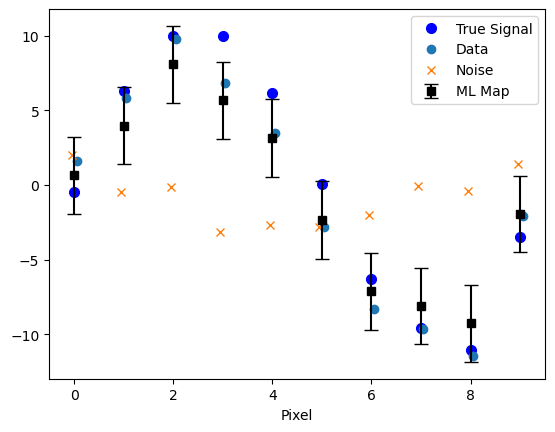

In [16]:
sn=10
signal = sn*np.sin(2*np.pi*pix/npix)
noise = np.random.multivariate_normal(mean, N, size=1).flatten()  # Shape: (100,)
data=signal+noise

map_binned = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(signal)) ## Solves P^TP (map) = P^T data
noise_binned = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(noise)) ## Solves P^TP (map) = P^T data
data_map_binned = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(data)) ## Solves P^TP (map) = P^T data
data_map_ml = np.linalg.solve((Pw.T.dot(F).dot(Pw)),Pw.T.dot(F.dot(data)))
plt.plot(range(npix),map_binned,'ob',ms=7,label='True Signal')
plt.plot(np.arange(0,npix)+.05,data_map_binned,'o',label='Data')
plt.plot(np.arange(0,npix)-.05,noise_binned,'x',label='Noise')
error=np.sqrt(np.diag(np.linalg.inv(Pw.T.dot(F).dot(Pw))))
plt.errorbar(range(npix),data_map_ml,yerr=error,fmt='ks',capsize=5,label='ML Map')
plt.xlabel('Pixel')
plt.legend()

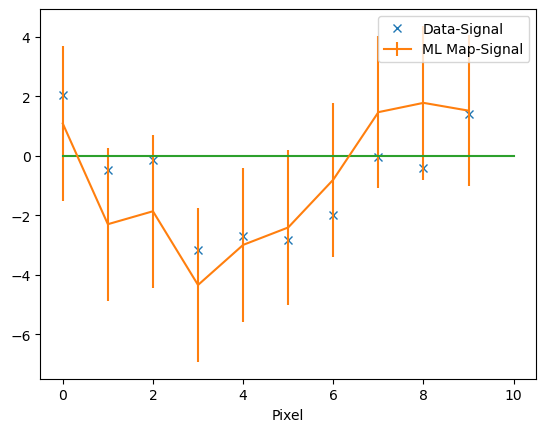

In [17]:
plt.plot(range(npix),(data_map_binned-map_binned),'x',label='Data-Signal')
error=np.sqrt(np.diag(np.linalg.inv(Pw.T.dot(F).dot(Pw))))
plt.errorbar(range(npix),(data_map_ml-map_binned),yerr=error,label='ML Map-Signal')
plt.plot([0,10],[0,0])
plt.xlabel('Pixel')
plt.legend()

0.04489348006879281 0.0387736783128222
1.150740076346469 1.1038915445300463


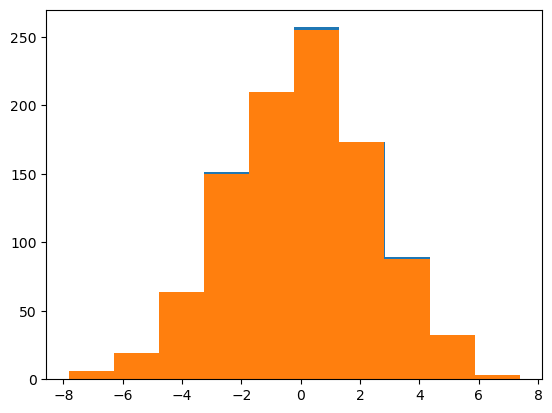

In [18]:
#do a bunch of noise simulations and see how well each estimator does
sn=1
signal = sn*np.sin(2*np.pi*pix/npix)
mean = np.zeros(nsamp)
nsim=1000
bmean=[]
bstd=[]
mlmean=[]
mlstd=[]
delta=[]
deltb=[]
for i in range(nsim):
    noise = np.random.multivariate_normal(mean, N, size=1).flatten()  # Shape: (100,)
    data=signal+noise
    map_binned = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(signal)) ## Solves P^TP (map) = P^T data
    data_map_binned = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(data)) ## Solves P^TP (map) = P^T data
    d1=data_map_binned-map_binned
    data_map_ml = np.linalg.solve((Pw.T.dot(F).dot(Pw)),Pw.T.dot(F.dot(data)))
    d2=data_map_ml-map_binned
    delta.append(d2[0])
    deltb.append(d1[0])
    bmean.append(np.mean(d1))
    bstd.append(np.std(d1))
    mlmean.append(np.mean(d2))
    mlstd.append(np.std(d2))
bstd=np.array(bstd)
#print(bstd)
plt.hist(bmean)
plt.hist(mlmean)
print(np.mean(bmean),np.mean(mlmean))
print(np.mean(bstd),np.mean(mlstd))
    

In [19]:
# How does this compare to the expected error on the ML Map?
error=np.sqrt(np.diag(np.linalg.inv(Pw.T.dot(F).dot(Pw))))
print(error)

[2.60920711 2.57216429 2.56795335 2.58556986 2.6003505  2.60124246
 2.58940325 2.5618362  2.58539925 2.53136464]


In [20]:
# It's not quite the same thing, as the historgramed stuff is the std of all 10 points from the "truth" while the 
# predicted noise is the predicted std for one point
print(np.std(delta),np.std(deltb))

2.6926834918779403 2.7141705024395875


So the std of the accuracy of the prediction of any one pixel is much larger than the scatter of the mean of all pixels across many simulations. This is because the pixel noise is very correlated,
so if one pixel has large noise so will all the others and all will give a similarly biased high estimate of the signal. So the std of those 10 estimates will be smaller. Probably best then to use the individual pixels std as a benchmark.

# Add in more detectors

In [21]:

# Define simulation parameters
nsamp = 100  # Number of time samples
npix = 20  # Number of sky pixels
N_det = 3    # Number of detectors
det_spacing = 1  # Separation between detectors in pixels
sigma = 0.5  # Beam width in pixel units

# Simulated pointing locations for the first detector
location = np.linspace(0, npix, nsamp)  # Example: Detector sweeps across pixels
# Extend to multiple detectors (each shifted by det_spacing)
detector_offsets = np.arange(N_det) * det_spacing  # Offsets for each detector

# Initialize the pointing matrix with multiple detectors
Pw = np.zeros((nsamp * N_det, npix))

eps = 1e-12  # Small value to prevent division by zero
# Fill the pointing matrix
for d, offset in enumerate(detector_offsets):  # Loop over detectors
    for i, p in enumerate(location):  # Loop over time samples
        index = i + d * nsamp  # New index for multiple detectors
        for j in range(npix):  # Loop over sky pixels
            Pw[index, j] = np.exp(-0.5 * ((p + offset - j) / sigma) ** 2)  # Gaussian weight
        row_sum = np.sum(Pw[index, :])
        if row_sum > 0:  # Only normalize if row sum is nonzero
            Pw[index, :] /= row_sum
        else:
            print(f"Warning: Row {index} has all zeros and cannot be normalized.")
        #Pw[index, :] /= (np.sum(Pw[index, :]) + eps)  # Add small constant
# Normalize row to sum to 1

# Pw now has shape (nsamp * N_det, npix), meaning all detectors are included



## Signal and Noise
Need to generate 3 copies for the 3 different detectors, so signal has size nsamp*3

In [22]:
## Put in the signal
signal = np.sin(np.linspace(0, 2 * np.pi, npix)) 

## Noise

# Define frequency-domain power spectrum (inverse covariance)
freq = np.fft.rfftfreq(nsamp)
inv_ps = 1 / (1 + (np.maximum(freq, freq[1] / 2) / 0.03) ** -3.5)

# Initialize the full noise correlation matrix F (block-diagonal)
F = np.zeros((nsamp * N_det, nsamp * N_det))

# Identity matrix for impulse response
I = np.eye(nsamp)

# Construct block-diagonal noise covariance (uncorrelated between detectors)
for d in range(N_det):  # Loop over detectors
    for i in range(nsamp):  # Loop over time samples
        row_idx = d * nsamp + i  # Index in full matrix
        col_start = d * nsamp  # Block placement (only within the same detector)

        # Generate noise correlation for a single detector
        noise_corr = np.fft.irfft(inv_ps * np.fft.rfft(I[i]), n=nsamp)

        # Assign to the block-diagonal part of F
        F[row_idx, col_start:col_start + nsamp] = noise_corr

# Add small identity term to avoid singular matrix issues
F += 1e-10 * np.eye(nsamp * N_det)

# Generate correlated noise realizations
L = np.linalg.cholesky(F)  # Cholesky decomposition
white_noise = np.random.randn(nsamp * N_det)  # White noise
correlated_noise = L @ white_noise  # Apply correlation



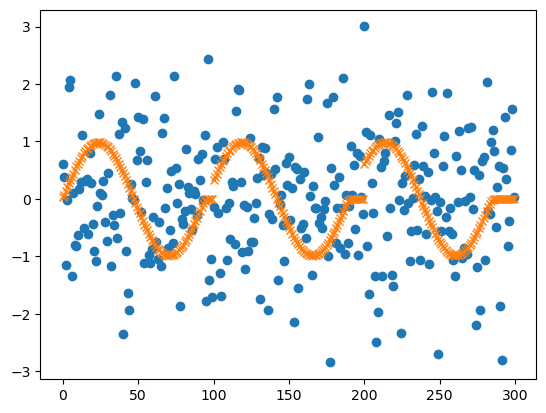

In [23]:
data=Pw.dot(signal)+ correlated_noise
plt.plot(correlated_noise,'o')
plt.plot(Pw.dot(signal),'x')

The zeros at the end are because the detectors are pointing "over the edge" and also the final value of the signal is zero. The first of these problems is evident in that the 3rd detector is the most shifted to the right and therefore sees even less of the actual field with signal. Presumably the inversion should take care of this.

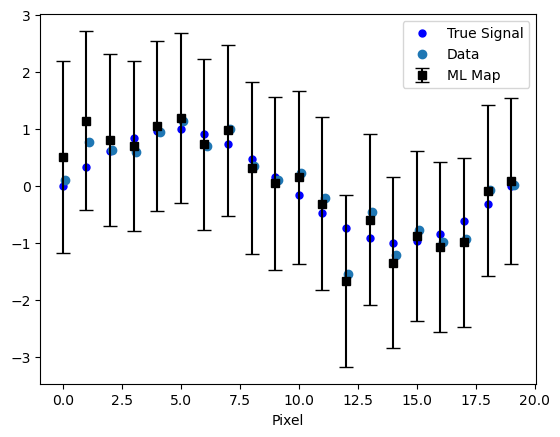

In [24]:
## Plot
#signal_map = np.linalg.solve((Pw.T.dot(Pw)), Pw.dot(signal)) ## Solves P^TP (map) = P^T signal
data_map = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(data)) ## Solves P^TP (map) = P^T data
data_map_ml = np.linalg.solve((Pw.T.dot(F).dot(Pw)),Pw.T.dot(F.dot(data)))
plt.plot(range(npix),signal,'ob',ms=5,label='True Signal')
plt.plot(np.arange(0,npix)+.1,data_map,'o',label='Data')
error=np.sqrt(np.diag(np.linalg.inv(Pw.T.dot(F).dot(Pw))))
plt.errorbar(range(npix),data_map_ml,yerr=error,fmt='ks',capsize=5,label='ML Map')
plt.xlabel('Pixel')
plt.legend()

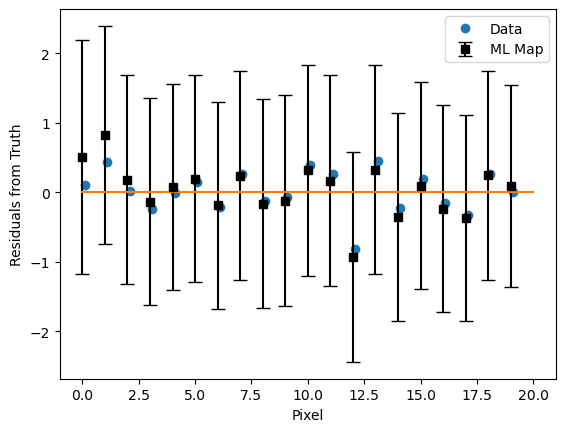

In [25]:
#look at the residuals
plt.plot(np.arange(0,npix)+.1,data_map-signal,'o',label='Data')
error=np.sqrt(np.diag(np.linalg.inv(Pw.T.dot(F).dot(Pw))))
plt.errorbar(range(npix),data_map_ml-signal,yerr=error,fmt='ks',capsize=5,label='ML Map')
plt.xlabel('Pixel')
plt.ylabel('Residuals from Truth')
plt.plot([0,20],[0,0])
plt.legend()

The error bars there seems too large; let's run simulated noise vectors to see if the spread is accurate

In [26]:
sn=1
signal = sn*np.sin(np.linspace(0, 2 * np.pi, npix)) 
nsim=100
bmean=[]
bstd=[]
mlmean=[]
mlstd=[]
delta=[]
deltb=[]
error=np.sqrt(np.diag(np.linalg.inv(Pw.T.dot(F).dot(Pw))))
for i in range(nsim):
    white_noise = np.random.randn(nsamp * N_det)  # White noise
    correlated_noise = L @ white_noise  # Apply correlation
    data=Pw.dot(signal)+correlated_noise
    #map_binned = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(signal)) ## Solves P^TP (map) = P^T data
    data_map_binned = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(data)) ## Solves P^TP (map) = P^T data
    d1=data_map_binned-signal#map_binned
    data_map_ml = np.linalg.solve((Pw.T.dot(F).dot(Pw)),Pw.T.dot(F.dot(data)))
    d2=data_map_ml-signal#map_binned
    delta.append(d2[1])
    deltb.append(d1[1])
    bmean.append(np.mean(d1))
    bstd.append(np.std(d1))
    mlmean.append(np.mean(d2))
    mlstd.append(np.std(d2))
bstd=np.array(bstd)
delta=np.array(delta)
deltb=np.array(deltb)
print('ML: ',np.mean(delta),np.std(delta))
print('Unweighted: ',np.mean(deltb),np.std(deltb),error[0])

ML:  -0.022125424314605974 0.5621082724903187
Unweighted:  -0.01549694227350788 0.5126942547550912 1.6877290721710183


### So the error is smaller than the predicted error; also weird that the ML map has a larger std than the unweighted map

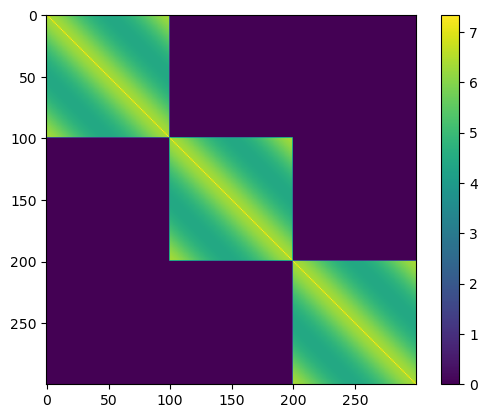

In [27]:
plt.imshow(np.linalg.inv(F))
plt.colorbar()


## Perhaps this has something to do with the periodic boundary conditions, which seem to leadd to unphysical correlations for elements very far from one another.
Maybe try simple noise first.

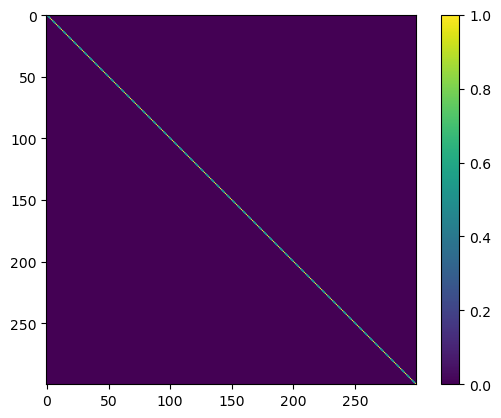

In [28]:
# Identity matrix for the noise matrix
I = np.eye(nsamp*N_det)
F = I
plt.imshow(np.linalg.inv(F))
plt.colorbar()

# Generate correlated noise realizations
L = np.linalg.cholesky(F)  # Cholesky decomposition
white_noise = np.random.randn(nsamp * N_det)  # White noise
correlated_noise = L @ white_noise  # Apply correlation


In [29]:
sn=1
signal = sn*np.sin(np.linspace(0, 2 * np.pi, npix)) 
nsim=100
bmean=[]
bstd=[]
mlmean=[]
mlstd=[]
delta=[]
deltb=[]
error=np.sqrt(np.diag(np.linalg.inv(Pw.T.dot(F).dot(Pw))))
for i in range(nsim):
    white_noise = np.random.randn(nsamp * N_det)  # White noise
    correlated_noise = L @ white_noise  # Apply correlation
    data=Pw.dot(signal)+correlated_noise
    #map_binned = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(signal)) ## Solves P^TP (map) = P^T data
    data_map_binned = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(data)) ## Solves P^TP (map) = P^T data
    d1=data_map_binned-signal#map_binned
    data_map_ml = np.linalg.solve((Pw.T.dot(F).dot(Pw)),Pw.T.dot(F.dot(data)))
    d2=data_map_ml-signal#map_binned
    delta.append(d2[1])
    deltb.append(d1[1])
    bmean.append(np.mean(d1))
    bstd.append(np.std(d1))
    mlmean.append(np.mean(d2))
    mlstd.append(np.std(d2))
bstd=np.array(bstd)
delta=np.array(delta)
deltb=np.array(deltb)
print('ML: ',np.mean(delta),np.std(delta))
print('Unweighted: ',np.mean(deltb),np.std(deltb),error[0],np.mean(bstd))

ML:  0.029109835107029226 0.5199155014743804
Unweighted:  0.029109835107029226 0.5199155014743804 0.7913208504185167 0.4354319309282053


Looks like the scatter in an individual pixel is still a factor of 1.5 too small, as is the mean std of all pixels from truth. The problem is that different pixels have different projected errors because of the different coverage. 

In [30]:
print(error)

[0.79132085 0.5653695  0.4508531  0.41991867 0.41537799 0.41474788
 0.41466095 0.41464897 0.41464732 0.41464709 0.41464705 0.41464702
 0.41464684 0.4146455  0.41463581 0.41456546 0.41405506 0.41035211
 0.3834988  0.17331141]


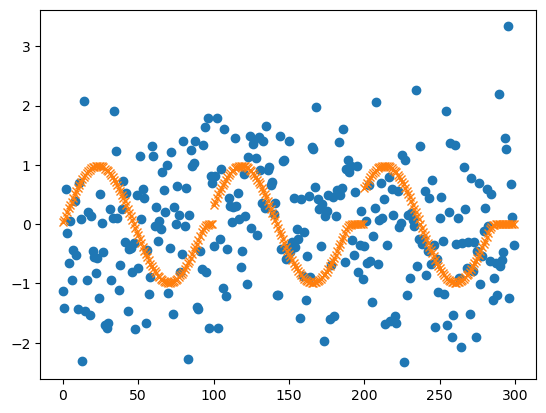

In [31]:
data=Pw.dot(signal)+ correlated_noise
plt.plot(correlated_noise,'o')
plt.plot(Pw.dot(signal),'x')

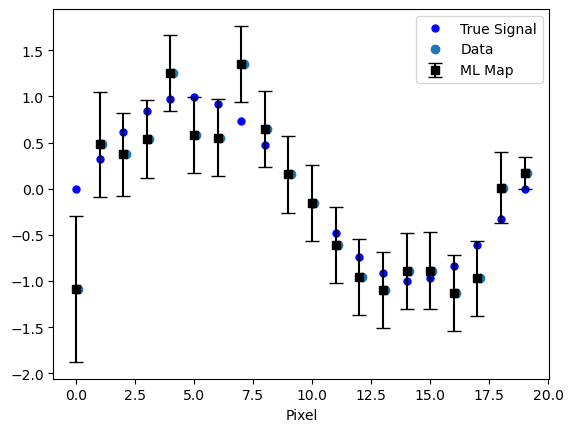

In [32]:
data_map = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(data)) ## Solves P^TP (map) = P^T data
data_map_ml = np.linalg.solve((Pw.T.dot(F).dot(Pw)),Pw.T.dot(F.dot(data)))
plt.plot(range(npix),signal,'ob',ms=5,label='True Signal')
plt.plot(np.arange(0,npix)+.1,data_map,'o',label='Data')
error=np.sqrt(np.diag(np.linalg.inv(Pw.T.dot(F).dot(Pw))))
plt.errorbar(range(npix),data_map_ml,yerr=error,fmt='ks',capsize=5,label='ML Map')
plt.xlabel('Pixel')
plt.legend()

Why is the error on the last pixel so small? Isn't that the pixel that is covered the least?

In [33]:
# Find the rows where the last column is greater than 0.1
for j in range(npix):
    indices = np.where(Pw[:, j] > 0.1)  # Returns tuple (row indices,)
    print(j, np.size(indices))
# Print indices and corresponding elements
#for i in indices[0]:  # Extract row indices from tuple
#    print(f"Index ({i}) -> Element {Pw[i, -1]:.3f}")


0 7
1 17
2 26
3 30
4 30
5 30
6 30
7 30
8 30
9 30
10 30
11 30
12 30
13 30
14 30
15 30
16 30
17 30
18 30
19 45


So the answer is no, in this case the last pixel is covered most often while the first pixel least often

In [34]:
print(error[1],np.std(delta))

0.5653695031252883 0.5199155014743804


very close; Let's try it again with the correlated noise

In [35]:
### Pointing Matrix

N_det=3


det_spacing = 1  # Separation between detectors in pixels
sigma = 0.5  # Beam width in pixel units

# Simulated pointing locations for the first detector
location = np.linspace(0, npix, nsamp)  # Example: Detector sweeps across pixels
# Extend to multiple detectors (each shifted by det_spacing)
detector_offsets = np.arange(N_det) * det_spacing  # Offsets for each detector

# Initialize the pointing matrix with multiple detectors
Pw = np.zeros((nsamp * N_det, npix))

eps = 1e-12  # Small value to prevent division by zero
# Fill the pointing matrix
for d, offset in enumerate(detector_offsets):  # Loop over detectors
    for i, p in enumerate(location):  # Loop over time samples
        index = i + d * nsamp  # New index for multiple detectors
        for j in range(npix):  # Loop over sky pixels
            Pw[index, j] = np.exp(-0.5 * ((p + offset - j) / sigma) ** 2)  # Gaussian weight
        row_sum = np.sum(Pw[index, :])
        if row_sum > 0:  # Only normalize if row sum is nonzero
            Pw[index, :] /= row_sum
        else:
            print(f"Warning: Row {index} has all zeros and cannot be normalized.")
        #Pw[index, :] /= (np.sum(Pw[index, :]) + eps)  # Add small constant


## Noise
# Define frequency-domain power spectrum (inverse covariance)
freq = np.fft.rfftfreq(nsamp)
inv_ps = 1 / (1 + (np.maximum(freq, freq[1] / 2) / 0.03) ** -3.5)

# Initialize the full noise correlation matrix F (block-diagonal)
F = np.zeros((nsamp * N_det, nsamp * N_det))

# Identity matrix for impulse response
I = np.eye(nsamp)

# Construct block-diagonal noise covariance (uncorrelated between detectors)
for d in range(N_det):  # Loop over detectors
    for i in range(nsamp):  # Loop over time samples
        row_idx = d * nsamp + i  # Index in full matrix
        col_start = d * nsamp  # Block placement (only within the same detector)

        # Generate noise correlation for a single detector
        noise_corr = np.fft.irfft(inv_ps * np.fft.rfft(I[i]), n=nsamp)

        # Assign to the block-diagonal part of F
        F[row_idx, col_start:col_start + nsamp] = noise_corr

# Add small identity term to avoid singular matrix issues
F += 1e-10 * np.eye(nsamp * N_det)

# Generate correlated noise realizations
L = np.linalg.cholesky(F)  # Cholesky decomposition

In [36]:
sn=5
signal = sn*np.sin(np.linspace(0, 2 * np.pi, npix)) 
nsim=1000
bmean=[]
bstd=[]
mlmean=[]
mlstd=[]
delta=[]
deltb=[]
error=np.sqrt(np.diag(np.linalg.inv(Pw.T.dot(F).dot(Pw))))
data_map_ml=np.zeros((npix,nsim))
N = np.linalg.inv(F)  # Compute true noise covariance
L_N = np.linalg.cholesky(N)  # Cholesky decomposition of noise covariance

for i in range(nsim):
    white_noise = np.random.randn(nsamp * N_det)  # White noise
    correlated_noise = L_N @ white_noise  # Apply correlation
    data=Pw.dot(signal)+correlated_noise
    #map_binned = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(signal)) ## Solves P^TP (map) = P^T data
    data_map_binned = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(data)) ## Solves P^TP (map) = P^T data
    d1=data_map_binned-signal#map_binned
    data_map_ml[:,i] = np.linalg.solve((Pw.T.dot(F).dot(Pw)),Pw.T.dot(F.dot(data)))
    d2=data_map_ml[:,i]-signal#map_binned
    delta.append(d2[1])
    deltb.append(d1[1])
    bmean.append(np.mean(d1))
    bstd.append(np.std(d1))
    mlmean.append(np.mean(d2))
    mlstd.append(np.std(d2))
bstd=np.array(bstd)
delta=np.array(delta)
deltb=np.array(deltb)
print('ML: ',np.mean(delta),np.std(delta))
print('Unweighted: ',np.mean(deltb),np.std(deltb),error[1],np.mean(bstd))

ML:  -0.11865906098485643 1.5588922207921845
Unweighted:  -0.1096551848001426 2.0322458464446735 1.5720417241557618 0.9513596161553032


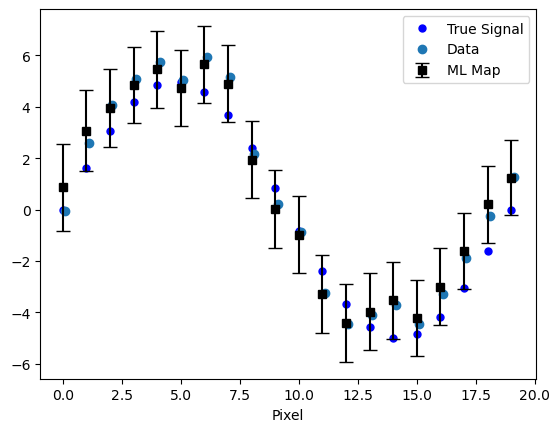

In [37]:
data_map = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(data)) ## Solves P^TP (map) = P^T data
#data_map_ml = np.linalg.solve((Pw.T.dot(F).dot(Pw)),Pw.T.dot(F.dot(data)))
plt.plot(range(npix),signal,'ob',ms=5,label='True Signal')
plt.plot(np.arange(0,npix)+.1,data_map,'o',label='Data')
error=np.sqrt(np.diag(np.linalg.inv(Pw.T.dot(F).dot(Pw))))
plt.errorbar(range(npix),data_map_ml[:,-1],yerr=error,fmt='ks',capsize=5,label='ML Map')
plt.xlabel('Pixel')
plt.legend()

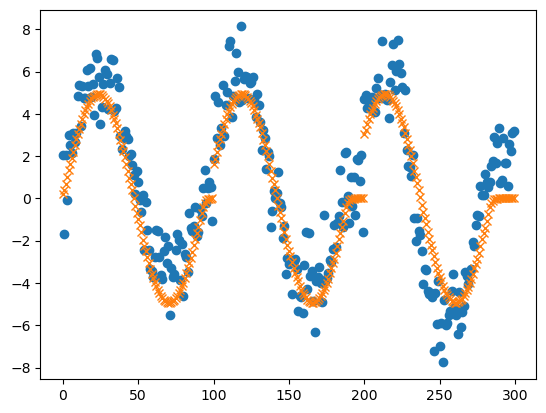

In [38]:
data=Pw.dot(signal)+ correlated_noise
plt.plot(data,'o')
plt.plot(Pw.dot(signal),'x')

ok everything works now. It's worth noting that the noise in each sample has variance ~7, corresponding to RMS of about 2.7 and yet the error bar on pixel 1, which is pointed at 17 times, is about 1.6. You might expect an error bar of 2.7/4, but that is an overcount because each hit is not with a weight of 1.

In [39]:
print('Pixel, Weighted Number of Samples, Simple Noise Prediction, Actual Noise Prediction')
print('--------------')
for i in range(npix):
    sum1=np.sum(Pw[:, i]) 
    print(i,sum1,np.sqrt(N[i,i])/np.sqrt(sum1),error[i])

Pixel, Weighted Number of Samples, Simple Noise Prediction, Actual Noise Prediction
--------------
0 3.180193346509399 1.519710376243712 1.6877290721710183
1 7.958138559685144 0.960686842899129 1.5720417241557618
2 12.702696024593305 0.7603956754836947 1.509650489810854
3 14.784029723529466 0.7048410306158172 1.4907713816097632
4 14.849942347736047 0.7032750451261428 1.4865655990826758
5 14.849999999046364 0.703273679982465 1.4879689094172888
6 14.850000000000001 0.7032736799598835 1.4937244976370057
7 14.849999999892352 0.7032736799624328 1.5012135359786933
8 14.84999999979524 0.7032736799647322 1.5086039685062798
9 14.849999999718174 0.7032736799665572 1.5141905099049222
10 14.849999999668693 0.7032736799677288 1.516865520116151
11 14.849999999651644 0.7032736799681323 1.5161091892764522
12 14.849999999668695 0.7032736799677285 1.5120994819413218
13 14.849999999718174 0.7032736799665569 1.505454076918905
14 14.84999999979524 0.7032736799647317 1.4981067571258542
15 14.85000000000905 

# Add in moving signal

In [40]:
# Maybe first good to see how well this configuration would extract a stationary atmosphere drawn from a Kolmogorov spectrum

In [41]:
### Pointing Matrix

N_det=3
v_wind=  .17 #5m/s/h=1km=.005 *pi/180/60 = 17'. We are imagining 100 samples so that could be in 1/100 sec.
## We also assume 20 pixels, and the beam cover 10 degrees? in ~50 sec or 600'/50 s= 12'/s, so each pixel could be one arcminute


det_spacing = 1  # Separation between detectors in pixels
sigma = 0.5  # Beam width in pixel units

# Simulated pointing locations for the first detector
location = np.linspace(0, npix, nsamp)  # Example: Detector sweeps across pixels
# Extend to multiple detectors (each shifted by det_spacing)
detector_offsets = np.arange(N_det) * det_spacing  # Offsets for each detector

# Initialize the pointing matrix with multiple detectors
Pw = np.zeros((nsamp * N_det, npix))

eps = 1e-12  # Small value to prevent division by zero
# Fill the pointing matrix for d, offset in enumerate(detector_offsets):  # Loop over detectors
for d, offset in enumerate(detector_offsets):  # Loop over detectors
    for i, p in enumerate(location):  # Loop over time samples
        index = i + d * nsamp  # New index for multiple detectors
        
        wind_shift = v_wind * i  # Shift due to atmospheric motion
        
        for j in range(npix):  # Loop over sky pixels
            j_eff = j - wind_shift  # Shift pixel due to wind
            Pw[index, j] = np.exp(-0.5 * ((p + offset - j_eff) / sigma) ** 2)  # Gaussian weight
        
        row_sum = np.sum(Pw[index, :])
        if row_sum > 0:  # Normalize
            Pw[index, :] /= row_sum
        else:
            print(f"Warning: Row {index} has all zeros and cannot be normalized.")


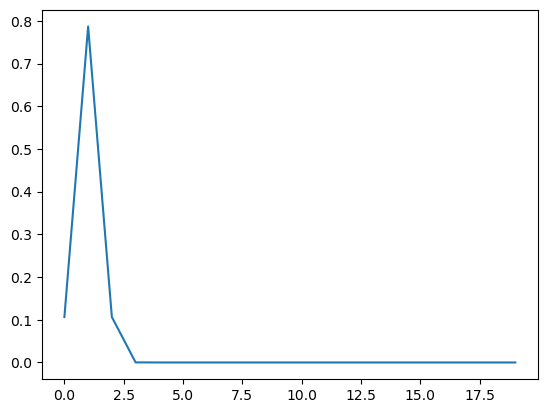

In [42]:
plt.plot(Pw[100,:])

/var/folders/yt/44r1mdln1k7_0595qvt97vd00000gn/T/ipykernel_12840/2048462600.py:10: RuntimeWarning: divide by zero encountered in power
  P_k = np.where(k >= 1.e-3, k**(-11/3), 0)  # Avoid division by zero
/var/folders/yt/44r1mdln1k7_0595qvt97vd00000gn/T/ipykernel_12840/2048462600.py:10: RuntimeWarning: invalid value encountered in power
  P_k = np.where(k >= 1.e-3, k**(-11/3), 0)  # Avoid division by zero


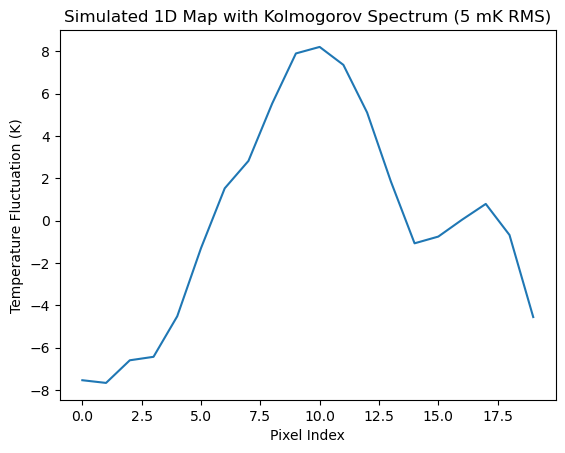

Final RMS of the simulated map: 5000.000 mK


In [43]:
#First do the static case:
# Define map size
npix = 20  # Number of pixels in the simulated map
target_rms = 5  # Target RMS fluctuation (5 mK)

# Generate wavenumbers
k = np.fft.fftfreq(npix) * npix  # Normalize k values

# Define the Kolmogorov power spectrum P(k) ∝ k^(-11/3)
P_k = np.where(k >= 1.e-3, k**(-11/3), 0)  # Avoid division by zero

# Generate Gaussian random field in Fourier space
rand_re = np.random.randn(npix)  # Real part
rand_im = np.random.randn(npix)  # Imaginary part
fourier_field = (rand_re + 1j * rand_im) * np.sqrt(P_k)

# Transform back to real space
simulated_map = np.fft.ifft(fourier_field).real  # Take only real part

# Normalize to 5 mK RMS
simulated_map -= np.mean(simulated_map)  # Zero mean
simulated_map *= target_rms / np.std(simulated_map)  # Scale to desired RMS

# Plot the simulated map
plt.plot(simulated_map)
plt.xlabel("Pixel Index")
plt.ylabel("Temperature Fluctuation (K)")
plt.title("Simulated 1D Map with Kolmogorov Spectrum (5 mK RMS)")
plt.show()

# Print verification
print(f"Final RMS of the simulated map: {np.std(simulated_map)*1e3:.3f} mK")


In [44]:
signal=simulated_map
# Analyze as before
### Pointing Matrix

N_det=3


det_spacing = 1  # Separation between detectors in pixels
sigma = 0.5  # Beam width in pixel units

# Simulated pointing locations for the first detector
location = np.linspace(0, npix, nsamp)  # Example: Detector sweeps across pixels
# Extend to multiple detectors (each shifted by det_spacing)
detector_offsets = np.arange(N_det) * det_spacing  # Offsets for each detector

# Initialize the pointing matrix with multiple detectors
Pw = np.zeros((nsamp * N_det, npix))

eps = 1e-12  # Small value to prevent division by zero
# Fill the pointing matrix
for d, offset in enumerate(detector_offsets):  # Loop over detectors
    for i, p in enumerate(location):  # Loop over time samples
        index = i + d * nsamp  # New index for multiple detectors
        for j in range(npix):  # Loop over sky pixels
            Pw[index, j] = np.exp(-0.5 * ((p + offset - j) / sigma) ** 2)  # Gaussian weight
        row_sum = np.sum(Pw[index, :])
        if row_sum > 0:  # Only normalize if row sum is nonzero
            Pw[index, :] /= row_sum
        else:
            print(f"Warning: Row {index} has all zeros and cannot be normalized.")
        #Pw[index, :] /= (np.sum(Pw[index, :]) + eps)  # Add small constant


## Noise
# Define frequency-domain power spectrum (inverse covariance)
freq = np.fft.rfftfreq(nsamp)
#SPT noise per pixel is roughly 1 mu K and that comes from beating down detector noise 
# [and atmospheric noise on larger scales] with multiple visits, 
#call it 3000 visits per pixel. That means each 100 second scan has detector noise of order 1 muK X \sqrt{3000} \sim 50 \mu K. 
noise_amp=0.05**2 # mK
inv_ps = 1./noise_amp / (1 + (np.maximum(freq, freq[1] / 2) / 0.03) ** -3.5)

# Initialize the full noise correlation matrix F (block-diagonal)
F = np.zeros((nsamp * N_det, nsamp * N_det))

# Identity matrix for impulse response
I = np.eye(nsamp)



# Construct block-diagonal noise covariance (uncorrelated between detectors)
for d in range(N_det):  # Loop over detectors
    for i in range(nsamp):  # Loop over time samples
        row_idx = d * nsamp + i  # Index in full matrix
        col_start = d * nsamp  # Block placement (only within the same detector)

        # Generate noise correlation for a single detector
        noise_corr = np.fft.irfft(inv_ps * np.fft.rfft(I[i]), n=nsamp)

        # Assign to the block-diagonal part of F
        F[row_idx, col_start:col_start + nsamp] = noise_corr

# Add small identity term to avoid singular matrix issues
F += 1e-10 * np.eye(nsamp * N_det)

# Generate correlated noise realizations
L = np.linalg.cholesky(F)  # Cholesky decomposition

In [45]:
nsim=1000
bmean=[]
bstd=[]
mlmean=[]
mlstd=[]
delta=[]
deltb=[]
data_map_ml=np.zeros((npix,nsim))
N = np.linalg.inv(F)  # Compute true noise covariance
N=noise_amp*N/N[0,0]
F=np.linalg.inv(N)
L_N = np.linalg.cholesky(N)  # Cholesky decomposition of noise covariance
error=np.sqrt(np.diag(np.linalg.inv(Pw.T.dot(F).dot(Pw))))

for i in range(nsim):
    white_noise = np.random.randn(nsamp * N_det)  # White noise
    correlated_noise = L_N @ white_noise  # Apply correlation
    data=Pw.dot(signal)+correlated_noise
    #map_binned = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(signal)) ## Solves P^TP (map) = P^T data
    data_map_binned = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(data)) ## Solves P^TP (map) = P^T data
    d1=data_map_binned-signal#map_binned
    data_map_ml[:,i] = np.linalg.solve((Pw.T.dot(F).dot(Pw)),Pw.T.dot(F.dot(data)))
    d2=data_map_ml[:,i]-signal#map_binned
    delta.append(d2[1])
    deltb.append(d1[1])
    bmean.append(np.mean(d1))
    bstd.append(np.std(d1))
    mlmean.append(np.mean(d2))
    mlstd.append(np.std(d2))
bstd=np.array(bstd)
delta=np.array(delta)
deltb=np.array(deltb)
print('ML: ',np.mean(delta),np.std(delta))
print('Unweighted: ',np.mean(deltb),np.std(deltb),error[1],np.mean(bstd))

ML:  0.00016751663902814685 0.02904367166922847
Unweighted:  -0.0004085723154171488 0.03793928686907729 0.029003237693265398 0.017100365967353367


In [46]:
print(N[0,0])

0.0025000000000000005


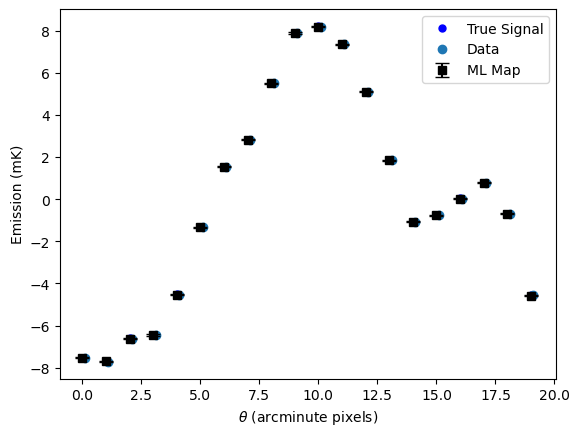

In [47]:
data_map = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(data)) ## Solves P^TP (map) = P^T data
#data_map_ml = np.linalg.solve((Pw.T.dot(F).dot(Pw)),Pw.T.dot(F.dot(data)))
plt.plot(range(npix),signal,'ob',ms=5,label='True Signal')
plt.plot(np.arange(0,npix)+.1,data_map,'o',label='Data')
error=np.sqrt(np.diag(np.linalg.inv(Pw.T.dot(F).dot(Pw))))
plt.errorbar(range(npix),data_map_ml[:,-1],yerr=error,fmt='ks',capsize=5,label='ML Map')
plt.xlabel('$\\theta$ (arcminute pixels)')
plt.ylabel('Emission (mK)')
plt.legend()

# Some SPT Details
Data: In 100 seconds, SPT scans 100 degrees spits out ~$10^4$ data points per detector in ~tens of thousands of detectors, pointing matrix
Model: 2D array of $2'$ pixels covering 100 sq deg ($10^5$ pixels) with values of CMB, atmosphere, velocity vector

SPT: 10 wafers with 269 tri-chroic pixels dual polarization, sampled at 150Hz 1.9 degree diameter FOV, so roughly in a single scan we get 
(150 Hz)*(100 sec) "maps" each with 2700 pixels filling an area of $\pi (1.9^\circ/2)^2$.

This means each pixel has an area of $(\pi 1.9^2/4)\times  60^2/2690=4$ square arcminutes. In 1 sec, roughly the same field remains in view and 150 such maps are output.
The azimuthal scan (left-right movement) covers ~15-20 degrees.
The telescope scans at a speed of ~0.25–0.4 degrees per second in azimuth.
A full left-right azimuthal scan takes ~30–60 seconds.
They output data at about 200 times per second. 

This means that a single detector is moving at roughly 15' per second or 0.15' per every 100 seconds. 
If we assume that the 100 samples above are 1 second and it covers 20 pixels, that means each pixel could be roughly 1'. Probably good to have the beam equal to that as well not half of it.

## 1D Implemenation
There are 2700 detectors in a circular region of diameter 1.9 degrees. Let's assume each detector has a beam width of 1'. For simplicity let's focus on N_det detectors in the y=0 plane. The total area of all 2700 detectors is $2700\pi (D_d/2)^2$ where $D_d$ is the diameter of the detector. If we set that total area equal to the FOV, then we get $2700 D_d^2 = (1.9^\circ)^2$, or $D_d=2.2'$. So across the $y=0$ axis, there could be as many as 50 detectors in a straight line. So $N_{det}<=50.$ The pixel separation det_spacing$=1.9^\circ/N_{det}$.

The number of samples in a single left-right scan [1-way] can be obatined assuming 50 seconds per scan and 150Hz, so $nsamp=7500$. A sample corresponds to a 1/150 sec interval, so in that time the detector has moved $(100\times 60'/30 s)\times 1/150 s = 1.3'$. But the line location = np.linspace(0, npix, nsamp) takes care of that.

If we are interested only in the large scale signal, we can make pixels of size $1^\circ$ so npix=100. This means in pixel units, det_spacing$=1.9/N_{det}$



In [48]:
# Define simulation parameters
pixel_size=1. #degree
nsamp = 7500  # Number of time samples
npix = 100  # Number of sky pixels
N_det = 3    # Number of detectors
det_spacing = 1.9/N_det  # Separation between detectors in pixels
sigma = pixel_size/25.  # Beam width in pixel units

# Simulated pointing locations for the first detector
location = np.linspace(0, npix, nsamp)  # Example: Detector sweeps across pixels
# Extend to multiple detectors (each shifted by det_spacing)
detector_offsets = np.arange(N_det) * det_spacing  # Offsets for each detector

# Initialize the pointing matrix with multiple detectors
Pw = np.zeros((nsamp * N_det, npix))

eps = 1e-12  # Small value to prevent division by zero
# Fill the pointing matrix
for d, offset in enumerate(detector_offsets):  # Loop over detectors
    for i, p in enumerate(location):  # Loop over time samples
        index = i + d * nsamp  # New index for multiple detectors
        for j in range(npix):  # Loop over sky pixels
            Pw[index, j] = np.exp(-0.5 * ((p + offset - j) / sigma) ** 2)  # Gaussian weight
        row_sum = np.sum(Pw[index, :])
        if row_sum > 0:  # Only normalize if row sum is nonzero
            Pw[index, :] /= row_sum
        else:
            print(f"Warning: Row {index} has all zeros and cannot be normalized.")

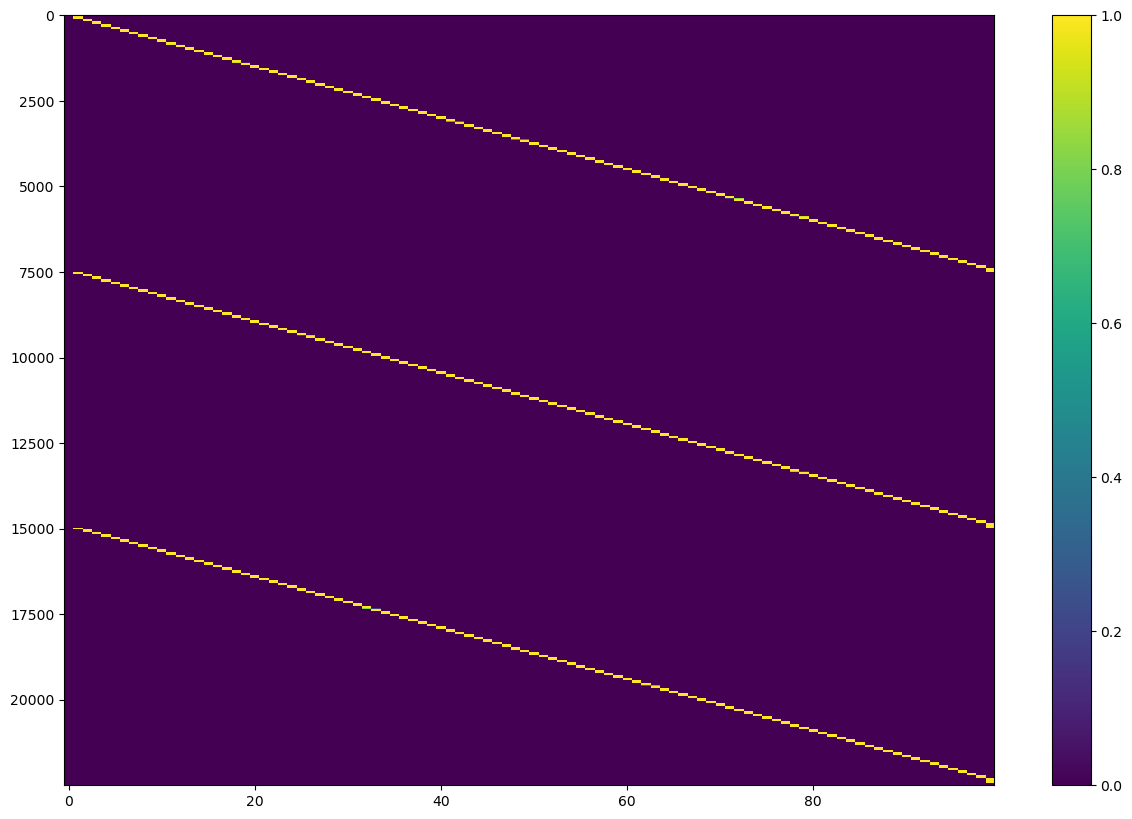

In [49]:
fig, ax = plt.subplots(figsize=(15, 10))  # Width=15, Height=10 (adjust as needed)

# Display the matrix as an image
im = ax.imshow(Pw, aspect='auto', cmap='viridis', interpolation='nearest')

# Add colorbar
plt.colorbar(im)


In [50]:
## Noise
## Noise
# Define frequency-domain power spectrum (inverse covariance)
freq = np.fft.rfftfreq(nsamp)
#SPT noise per pixel is roughly 1 mu K and that comes from beating down detector noise 
# [and atmospheric noise on larger scales] with multiple visits, 
#call it 3000 visits per pixel. That means each 100 second scan has detector noise of order 1 muK X \sqrt{3000} \sim 50 \mu K. 
noise_amp=0.1**2 # mK
inv_ps = 1./noise_amp / (1 + (np.maximum(freq, freq[1] / 2) / 0.03) ** -3.5)

# Initialize the full noise correlation matrix F (block-diagonal)
F = np.zeros((nsamp * N_det, nsamp * N_det))

# Identity matrix for impulse response
I = np.eye(nsamp)



# Construct block-diagonal noise covariance (uncorrelated between detectors)
for d in range(N_det):  # Loop over detectors
    for i in range(nsamp):  # Loop over time samples
        row_idx = d * nsamp + i  # Index in full matrix
        col_start = d * nsamp  # Block placement (only within the same detector)

        # Generate noise correlation for a single detector
        noise_corr = np.fft.irfft(inv_ps * np.fft.rfft(I[i]), n=nsamp)

        # Assign to the block-diagonal part of F
        F[row_idx, col_start:col_start + nsamp] = noise_corr

# Add small identity term to avoid singular matrix issues
F += 1e-10 * np.eye(nsamp * N_det)


In [51]:
sn=5
signal = sn*np.sin(np.linspace(0, 2 * np.pi, npix)) 
nsim=1
bmean=[]
bstd=[]
mlmean=[]
mlstd=[]
delta=[]
deltb=[]
data_map_ml=np.zeros((npix,nsim))
N = np.linalg.inv(F)  # Compute true noise covariance
N=noise_amp*N/N[0,0]
F=np.linalg.inv(N)
L_N = np.linalg.cholesky(N)  # Cholesky decomposition of noise covariance
error=np.sqrt(np.diag(np.linalg.inv(Pw.T.dot(F).dot(Pw))))
print('here')
for i in range(nsim):
    white_noise = np.random.randn(nsamp * N_det)  # White noise
    correlated_noise = L_N @ white_noise  # Apply correlation
    data=Pw.dot(signal)+correlated_noise
    print('here')
#map_binned = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(signal)) ## Solves P^TP (map) = P^T data
    data_map_binned = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(data)) ## Solves P^TP (map) = P^T data
    d1=data_map_binned-signal#map_binned
    data_map_ml[:,i] = np.linalg.solve((Pw.T.dot(F).dot(Pw)),Pw.T.dot(F.dot(data)))
    d2=data_map_ml[:,i]-signal#map_binned
    delta.append(d2[1])
    deltb.append(d1[1])
    bmean.append(np.mean(d1))
    bstd.append(np.std(d1))
    mlmean.append(np.mean(d2))
    mlstd.append(np.std(d2))
bstd=np.array(bstd)
delta=np.array(delta)
deltb=np.array(deltb)
print('ML: ',np.mean(delta),np.std(delta))
print('Unweighted: ',np.mean(deltb),np.std(deltb),error[1],np.mean(bstd))

here
here
ML:  8.22094287917241e-05 0.0
Unweighted:  -0.025897081300557956 0.0 8.309165573423675e-05 0.018055369920392063


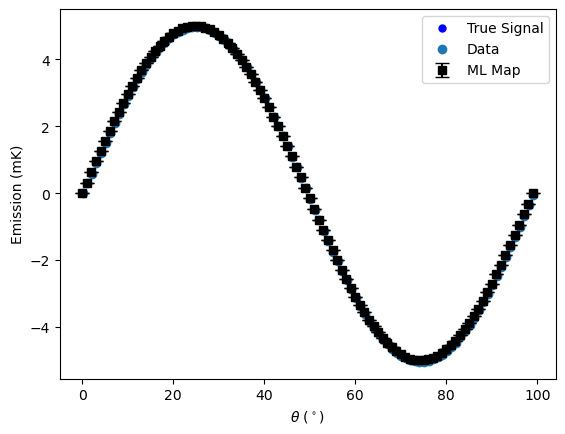

In [53]:
data_map = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(data)) ## Solves P^TP (map) = P^T data
#data_map_ml = np.linalg.solve((Pw.T.dot(F).dot(Pw)),Pw.T.dot(F.dot(data)))
plt.plot(range(npix),signal,'ob',ms=5,label='True Signal')
plt.plot(np.arange(0,npix)+.1,data_map,'o',label='Data')
error=np.sqrt(np.diag(np.linalg.inv(Pw.T.dot(F).dot(Pw))))
plt.errorbar(range(npix),data_map_ml[:,-1],yerr=error,fmt='ks',capsize=5,label='ML Map')
plt.xlabel('$\\theta$ ($^\circ$)')
plt.ylabel('Emission (mK)')
plt.legend()

In [54]:
print(np.sqrt(N[0,0]))
print(error)

0.1
[1.11924696e-04 8.30916557e-05 1.15089363e-04 1.37277959e-04
 1.55965923e-04 1.72300051e-04 1.86898038e-04 2.00139645e-04
 2.12278575e-04 2.23494512e-04 2.33920382e-04 2.43657905e-04
 2.52787049e-04 2.61372087e-04 2.69465626e-04 2.77111392e-04
 2.84346204e-04 2.91201408e-04 2.97703942e-04 3.03877145e-04
 3.09741371e-04 3.15314476e-04 3.20612198e-04 3.25648463e-04
 3.30435628e-04 3.34984687e-04 3.39305434e-04 3.43406599e-04
 3.47295966e-04 3.50980471e-04 3.54466283e-04 3.57758875e-04
 3.60863092e-04 3.63783196e-04 3.66522926e-04 3.69085534e-04
 3.71473830e-04 3.73690219e-04 3.75736736e-04 3.77615080e-04
 3.79326653e-04 3.80872583e-04 3.82253764e-04 3.83470882e-04
 3.84524448e-04 3.85414822e-04 3.86142244e-04 3.86706858e-04
 3.87108729e-04 3.87347865e-04 3.87424228e-04 3.87337746e-04
 3.87088315e-04 3.86675802e-04 3.86100034e-04 3.85360796e-04
 3.84457807e-04 3.83390709e-04 3.82159041e-04 3.80762213e-04
 3.79199478e-04 3.77469903e-04 3.75572339e-04 3.73505379e-04
 3.71267336e-04 3.68

So for this longwength mode that corresponds to $l=3.6$, with detector noise RMS equal to 0.05 mK per sample, each one-degree pixel signal is detected with an error of order 3.e-4 mK = 0.3 $\mu$K.

chatgpt says for SPT, “For any system: σtime sample\=Noise Spectral Density (pA/Hz)Sampling Frequency (Hz)\\sigma\_{\\text{time sample}} = \\frac{\\text{Noise Spectral Density (pA/\\(\\sqrt{\\text{Hz}}\\))}}{\\sqrt{\\text{Sampling Frequency (Hz)}}}σtime sample​\=Sampling Frequency (Hz)​Noise Spectral Density (pA/Hz​)​If you're using a **different sampling frequency**, just plug in the appropriate value.”

For SPT-3G-like numbers, expect the time-domain noise to be about 10× smaller than the frequency-domain noise. “If the **RMS noise per sample** is **1 pA** (as calculated before), the corresponding temperature noise is: $σ_T=\frac{1 pA}{10 pA/mK}=0.1$ mK.\sigma\_T = \\frac{1 \\text{ pA}}{10 \\text{ pA/mK}} = 0.1 \\text{ mK}.σT​\=10 pA/mK1 pA​\=0.1$ mK.”

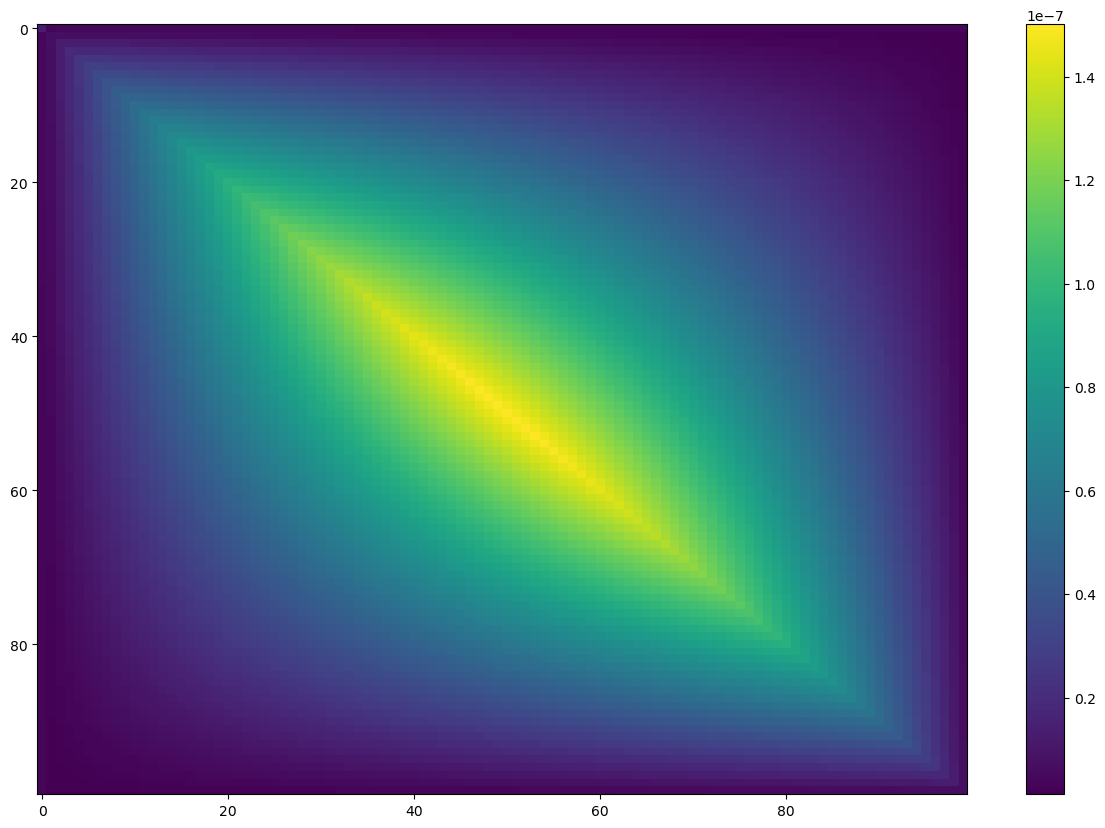

In [55]:
ematrix=np.linalg.inv(Pw.T.dot(F).dot(Pw))
fig, ax = plt.subplots(figsize=(15, 10))  # Width=15, Height=10 (adjust as needed)

# Display the matrix as an image
im = ax.imshow(ematrix, aspect='auto', cmap='viridis', interpolation='nearest')

# Add colorbar
plt.colorbar(im)
